# **Import Library**

In [1]:
# Import necessary libraries
import os
import zipfile
import shutil
import math
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image as tf_image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image as tf_image
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import tensorflow as tf
import requests
import scipy

## **GPU TENSORFLOW CONFIG**

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
# Set GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_virtual_device_configuration(gpu,[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])


# **PATH LOCATION**

In [4]:
# Specify the root directory and zip file path
base_dir = r"./Rock_Paper_Scissor"
if not os.path.exists(base_dir):
    os.makedirs(base_dir)
zip_file_path = os.path.join("rockpaperscissors.zip")
extracted_dir = os.path.join(base_dir, "dataset")

## **Download Dataset**

In [ ]:
# Specify the URL for the dataset zip file
dataset_url = "https://github.com/dicodingacademy/assets/releases/download/release/rockpaperscissors.zip"

# Download the zip file using requests
response = requests.get(dataset_url)
with open(zip_file_path, 'wb') as zip_file:
    zip_file.write(response.content)

## **Extract Dataset**

In [5]:
# Extract the dataset into the "dataset" folder
with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
    zip_ref.extractall(extracted_dir)

## **Train Val Folder and Prediction Classes**

In [6]:
# Define directories for train and validation sets
train_dir = os.path.join(extracted_dir, "train")
validation_dir = os.path.join(extracted_dir, "val")

# Ensure train and validation directories exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

classes = ['paper', 'rock', 'scissors']

# **Preprocessing Data**

## **Split Folder into Train and Val**

In [7]:
# Split each class into train and validation sets
for class_name in classes:
    class_images = os.listdir(os.path.join(extracted_dir, "rockpaperscissors", class_name))

    # Validation and Train 0.4 and  0.6
    split_index = math.ceil(0.6 * len(class_images))

    train_images = class_images[:split_index]
    val_images = class_images[split_index:]

    for image in train_images:
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        shutil.copy(os.path.join(extracted_dir, "rockpaperscissors", class_name, image), os.path.join(train_dir, class_name, image))

    for image in val_images:
        os.makedirs(os.path.join(validation_dir, class_name), exist_ok=True)
        shutil.copy(os.path.join(extracted_dir, "rockpaperscissors", class_name, image), os.path.join(validation_dir, class_name, image))

## **Data Generator Config / Augment**

In [8]:
# Create data augment
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(200, 200),
    batch_size=16,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(200, 200),
    batch_size=16,
    class_mode='categorical'
)

Found 1314 images belonging to 3 classes.


Found 874 images belonging to 3 classes.


# **Choose Model**

## **Sequential Model**

In [10]:
# Build the Sequential model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [11]:
# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
# Get summary from the cnn model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 128)      0

# **Train Model**

In [13]:
checkpoint = ModelCheckpoint(r"./model/best_model_train.h5",
                                   save_best_only=True,
                                   monitor='val_loss',
                                   mode='max',
                                   verbose=1)

# Early stopping to stop training if there is no improvement in validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

# Create Log Event
logdir='logs'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [14]:
# Train the model
hist = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[checkpoint, early_stopping, tensorboard_callback]
)

Epoch 1/20
82/82 [==============================] - ETA: 0s - loss: 1.1859 - accuracy: 0.4399
Epoch 1: accuracy improved from -inf to 0.43991, saving model to ./model\best_model_train.h5
82/82 [==============================] - 40s 433ms/step - loss: 1.1859 - accuracy: 0.4399 - val_loss: 0.8796 - val_accuracy: 0.7083
Epoch 2/20
82/82 [==============================] - ETA: 0s - loss: 0.9234 - accuracy: 0.5724
Epoch 2: accuracy improved from 0.43991 to 0.57242, saving model to ./model\best_model_train.h5
82/82 [==============================] - 28s 339ms/step - loss: 0.9234 - accuracy: 0.5724 - val_loss: 0.6237 - val_accuracy: 0.7512
Epoch 3/20
82/82 [==============================] - ETA: 0s - loss: 0.6452 - accuracy: 0.7411
Epoch 3: accuracy improved from 0.57242 to 0.74114, saving model to ./model\best_model_train.h5
82/82 [==============================] - 20s 240ms/step - loss: 0.6452 - accuracy: 0.7411 - val_loss: 0.2927 - val_accuracy: 0.9201
Epoch 4/20
82/82 [===================

In [15]:
# Save the model for future use
model.save(r"./model/rock_paper_scissors_model.h5")

# **Plot Perfomance**

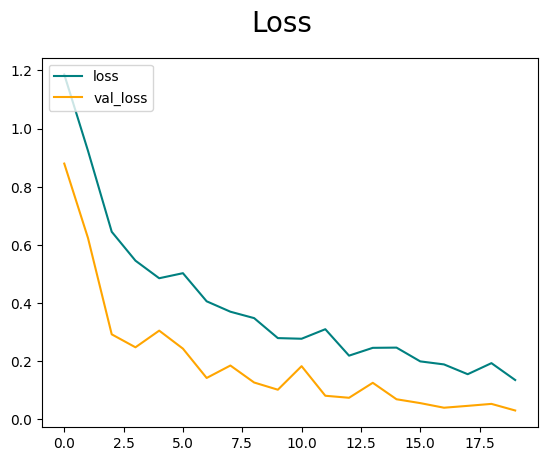

In [16]:
# Create Plot Perfomance between val_loss and loss
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

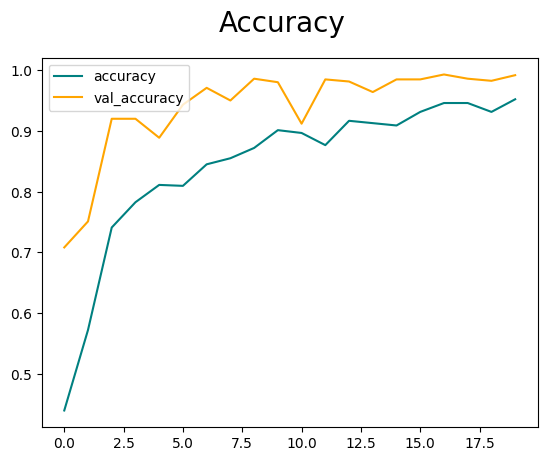

In [17]:
# Create Plot Perfomance between val_accuracy and accuracy
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# **Predict**

In [18]:
# Assuming you used this for training
train_datagen = ImageDataGenerator(rescale=1./255)

In [19]:
# Function to preprocess the uploaded image for prediction
def preprocess_uploaded_image(uploaded_image):
    img = tf_image.load_img(uploaded_image, target_size=(200, 200))
    img_array = tf_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return train_datagen.flow(img_array)

# Function to make predictions
def predict_uploaded_image(uploaded_image):
    processed_image = preprocess_uploaded_image(uploaded_image)
    predictions = model.predict(processed_image)
    class_index = np.argmax(predictions[0])
    classes = ['paper', 'rock', 'scissors']
    predicted_class = classes[class_index]
    predictions = predictions[0][class_index] * 100
    predictions = "{:.2f}".format(predictions)
    return predicted_class, predictions

In [20]:
# Load the trained model
model_path = r"./model/best_model_train.h5"
model = load_model(model_path)

In [21]:
# Tkinter GUI
class RockPaperScissorsApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Rock Paper Scissors Predictor")

        self.label = tk.Label(root, text="Select an image:")
        self.label.pack(pady=10)

        self.browse_button = tk.Button(root, text="Browse", command=self.browse_image)
        self.browse_button.pack(pady=10)

        self.result_label = tk.Label(root, text="")
        self.result_label.pack(pady=10)

    def browse_image(self):
        file_path = filedialog.askopenfilename(filetypes=[("Image files", "*.png;*.jpg;*.jpeg")])
        if file_path:
            self.display_image(file_path)
            predicted_class, probabilities = predict_uploaded_image(file_path)
            result_text = f"Prediction: {predicted_class}\nProbabilities: {probabilities}"
            self.result_label.config(text=result_text)

    def display_image(self, file_path):
        img = Image.open(file_path)
        img = img.resize((200, 200), Image.LANCZOS)
        img = ImageTk.PhotoImage(img)
        img_label = tk.Label(self.root, image=img)
        img_label.image = img
        img_label.pack(pady=10)


In [26]:
if __name__ == "__main__":
    root = tk.Tk()
    app = RockPaperScissorsApp(root)
    root.mainloop()

1/1 [==============================] - 0s 68ms/step
